In [1]:
#Importing necessary libraries 
import os
import cv2
import shutil
from imageio.v2 import imread
import numpy as np
import pandas as pd 
import tensorflow as tf


import matplotlib.pyplot as plt
plt.style.use('bmh')

from keras import backend as K
from keras.models import Sequential,Model
from keras.utils import to_categorical
from keras.optimizers import SGD,RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization,Input, concatenate,Activation 
from keras.utils.vis_utils import model_to_dot
from keras import regularizers 

from sklearn.model_selection import train_test_split
from IPython.display import SVG

import random

In [117]:
#Functions that will be needed later


#Evaluation fucntions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Model creation functions
def create_mlp(dim, regularizer=None):
    """Creates a simple two-layer MLP with inputs of the given dimension"""
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(4, activation="relu", kernel_regularizer=regularizer))
    return model

def create_cnn(width, height, depth):
    """
    Creates a CNN with the given input dimension and filter numbers.
    """
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(width, height, depth), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Return the CNN
    return model

In [118]:
#(1) Some initilisations
df_training_file = r'../../challenge_files/train.csv'
df_testing_file = r'../../challenge_files/test.csv'
img_col_name_name_in_training_file = 'example_path'
class_col_name_in_training_file = 'label'
training_images_directory = r'../../challenge_files/train_test_data_after_aug/train/'

In [4]:
#(2) Reading and preparing the training dataframe file

df = pd.read_csv(df_training_file)

#Convert the class column into strings
df.loc[:,class_col_name_in_training_file] = df.loc[:,class_col_name_in_training_file].astype(str)

#Keep only the basenames of the files in the example_path column
df.loc[:,img_col_name_name_in_training_file] = df.loc[:,img_col_name_name_in_training_file].apply(lambda x: os.path.basename(x))

df.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,1297.png
1,2,-1.989349,105.309496,2013,1199.png
2,0,1.223256,100.702217,2014,1348.png
3,0,-2.342948,103.890226,2008,2214.png
4,0,-0.126555,101.758175,2011,2220.png


In [5]:
# (3) Print a summary information about the number of training images per class
unique, counts = np.unique(np.array(df.loc[:,class_col_name_in_training_file]),return_counts=True)
percentage = counts/len(df)
counts_df = pd.DataFrame(zip(unique,counts,percentage), columns=['class','count','percentage'])
display(counts_df)

,class,count,percentage
0,0,860,0.501750
1,1,196,0.114352
2,2,658,0.383897


In [6]:
# Some notes:
# -----------
# - It seems that the training dataset is imbalanced. 
# class 1 seems to be the most under-represented
# 
# - We can use augmentation to balance the classes

In [7]:
# (4) Balancing the dataset
"""
balancing_img_gen = ImageDataGenerator(
                rotation_range=10, 
                width_shift_range=0.1, 
                height_shift_range=0.1,
                shear_range=0.15, 
                zoom_range=0.1,
                channel_shift_range = 10, 
                horizontal_flip=True)

# 4.1 generating more images for class 1
augmeted_class1_path = "../../challenge_files/test_aug/class1/"
for im_name in df.loc[df[class_col_name_in_training_file]=='1',img_col_name_name_in_training_file]:
    image_path = os.path.abspath(os.path.join(training_images_directory,str(im_name)))
    image = np.expand_dims(imread(image_path), 0)
    balancing_img_gen.fit(image)
    for x, val in zip(balancing_img_gen.flow(image,                    #image we chose
         save_to_dir=augmeted_class1_path,#this is where we figure out where to save
         save_prefix=f'{im_name}_1_aug', # it will save the images as 'aug_0912' some number for every new augmented image
         save_format='png'),range(random.randint(0,12))) :# here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
        pass

# 4.2 gnerating more images for class 2
augmeted_class2_path = "../../challenge_files/test_aug/class2/"
for im_name in df.loc[df[class_col_name_in_training_file]=='2',img_col_name_name_in_training_file]:
    image_path = os.path.abspath(os.path.join(training_images_directory,str(im_name)))
    image = np.expand_dims(imread(image_path), 0)
    balancing_img_gen.fit(image)
    for x, val in zip(balancing_img_gen.flow(image,                    #image we chose
         save_to_dir=augmeted_class2_path,#this is where we figure out where to save
         save_prefix=f'{im_name}_2_aug', # it will save the images as 'aug_0912' some number for every new augmented image
         save_format='png'),range(random.randint(0,3))) :# here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
        pass
print('image augmentation done ')
"""

# 4.3 add the newly generated images to the testing file and the testing directory
aug_image_names = []
aug_image_classes = []
aug_lon =[]
aug_lat =[]
aug_year=[]

num_required_augmnetations_for_class1= int(counts_df.loc[counts_df['class']=='0','count']) - int(counts_df.loc[counts_df['class']=='1','count'])
num_required_augmnetations_for_class2= int(counts_df.loc[counts_df['class']=='0','count']) - int(counts_df.loc[counts_df['class']=='2','count'])

sample_files_from_class1= random.sample([f'../../challenge_files/test_aug/class1/{file}' for file in os.listdir('../../challenge_files/test_aug/class1/') if file.split('.')[-1]=='png'],num_required_augmnetations_for_class1)
sample_files_from_class2= random.sample([f'../../challenge_files/test_aug/class2/{file}' for file in os.listdir('../../challenge_files/test_aug/class2/') if file.split('.')[-1]=='png'],num_required_augmnetations_for_class2)

augg_files = set(sample_files_from_class1).union(sample_files_from_class2)

for file in augg_files:
    
    aug_im_path = os.path.abspath(file)
    aug_image_name = os.path.basename(aug_im_path)
    dest_path = os.path.abspath(os.path.join(training_images_directory,aug_image_name))
    
    #copy to training file
    shutil.copy(aug_im_path, dest_path)
    #print(f'image {aug_image_name} copied')
    
    original_im_name = aug_image_name.split("_")[0]
    [[label,longitude,latitude , year]] = df.loc[df[img_col_name_name_in_training_file]==original_im_name,[class_col_name_in_training_file,'longitude','latitude','year']].values
    
    aug_image_names.append(aug_image_name)
    aug_image_classes.append(label)
    aug_lon.append(latitude)
    aug_lat.append(longitude)
    aug_year.append(year)

# 4.4 update trainig dataframe 
aug_df = pd.DataFrame(zip(aug_image_classes,aug_image_names,aug_lon,aug_lat,aug_year),columns=[class_col_name_in_training_file,img_col_name_name_in_training_file,'longitude','latitude','year'])

df_ = pd.concat([df,aug_df])
unique, counts = np.unique(np.array(df_.loc[:,class_col_name_in_training_file]),return_counts=True)
percentage = counts/len(df_)
counts_df = pd.DataFrame(zip(unique,counts,percentage), columns=['class','count','percentage'])
display(counts_df)
df_.to_csv('../train_.csv',index=False)

,class,count,percentage
0,0,860,0.333333
1,1,860,0.333333
2,2,860,0.333333


In [83]:
# (5) Split data into train-test data sets

X_img = df_.loc[:,img_col_name_name_in_training_file]
y = df_.loc[:,class_col_name_in_training_file]

# Split
train_img_x, val_img_x, train_y, val_y = train_test_split(X_img, y, 
                                              test_size = 0.1, 
                                              random_state = 27, 
                                              stratify=y)

# Training df for images
df_train_img = pd.DataFrame(columns=['image_name','category'])
df_train_img['image_name'] = train_img_x
df_train_img['category'] = train_y

# Test df for images 
df_test_img= pd.DataFrame(columns=['image_name','category'])
df_test_img['image_name'] = val_img_x
df_test_img['category'] = val_y

df_train_img.reset_index(drop=True, inplace=True)
df_test_img.reset_index(drop=True, inplace=True)

#Accounting for the other attributes
X_attr = df_.loc[:,['longitude','latitude']]

# Split 
train_attr_x, val_attr_x, train_y, val_y = train_test_split(X_attr, y, 
                                              test_size = 0.1, 
                                              random_state = 27, 
                                              stratify=y)


In [101]:
# (6) Append images into a list and prepare them to be input to the model.

# Images
train_images = df_train_img.loc[:,'image_name']
train_labels = df_train_img.loc[:,'category']

test_images = df_test_img.loc[:,'image_name']
test_labels = df_test_img.loc[:,'category']

# Train images
x_train = []
for i in train_images:
    image_path = os.path.abspath(os.path.join(training_images_directory,str(i)))
    img = cv2.imread(image_path)
    x_train.append(img)

# Train labels
y_train= to_categorical(train_labels)

# Test images
x_test = []
for i in test_images:
    image_path = os.path.abspath(os.path.join(training_images_directory,str(i)))
    img = cv2.imread(image_path)
    x_test.append(img)

# Test labels
y_test=to_categorical(test_labels)

# Normalize images
x_train = np.array(x_train, dtype="float") / 255.0
x_test = np.array(x_test, dtype="float") / 255.0



In [125]:
#building the cnn model for image processing

# create the MLP and CNN models
mlp = create_mlp(train_attr_x.shape[1], regularizer=regularizers.l1(0.005))
cnn = create_cnn(332, 332, 3)
 
# create the input to our final set of layers as the *output* of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])


# our final FC layer head will have two dense layers, the final one being our sigmoid head
x = Dense(64, activation="relu")(combinedInput)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation="softmax")(x)


# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

# Compile the model 
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model.compile(loss="categorical_crossentropy", metrics=['acc',f1_m,precision_m, recall_m], optimizer=opt)
 


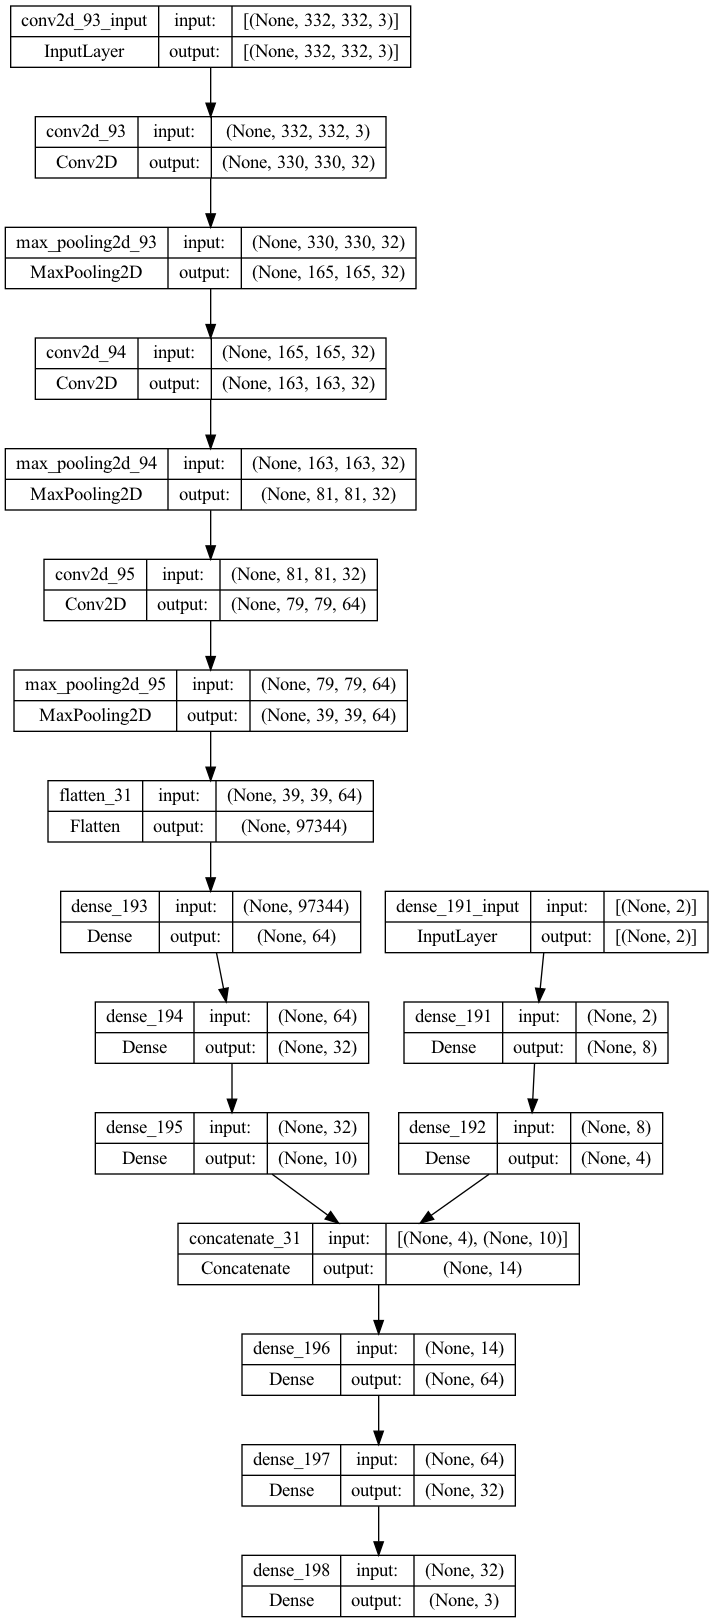

In [126]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [132]:
#start training
epochs = 25

model_history = model.fit([train_attr_x[:], x_train],y_train, 
              validation_data=([val_attr_x[:], val_y], y_test),
              epochs=5, 
              batch_size=3)

Epoch 1/5
774/774 [==============================] - ETA: 0s - loss: 0.8523 - acc: 0.5693 - f1_m: 0.4559 - precision_m: 0.5676 - recall_m: 0.4104WARNING:tensorflow:Model was constructed with shape (None, 332, 332, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 332, 332, 3), dtype=tf.float32, name='conv2d_93_input'), name='conv2d_93_input', description="created by layer 'conv2d_93_input'"), but it was called on an input with incompatible shape (None, 1).


ValueError: in user code:

    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 1499, in test_step
        y_pred = self(x, training=False)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "model_50" (type Functional).
    
    Input 0 of layer "conv2d_93" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer "model_50" (type Functional):
      • inputs=('tf.Tensor(shape=(None, 2), dtype=float64)', 'tf.Tensor(shape=(None, 1), dtype=string)')
      • training=False
      • mask=None


In [131]:
x_train.shape

(2322, 332, 332, 3)

In [135]:
# Compile the model 
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
cnn.compile(loss="categorical_crossentropy", metrics=['acc',f1_m,precision_m, recall_m], optimizer=opt)
 
model_history = cnn.fit(x_train,y_train, 
              validation_data=( val_y, y_test),
              epochs=5, 
              batch_size=10)

Epoch 1/5


ValueError: in user code:

    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/zhs412/opt/anaconda3/envs/Schneider_challenge/lib/python3.10/site-packages/keras/backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 10) are incompatible


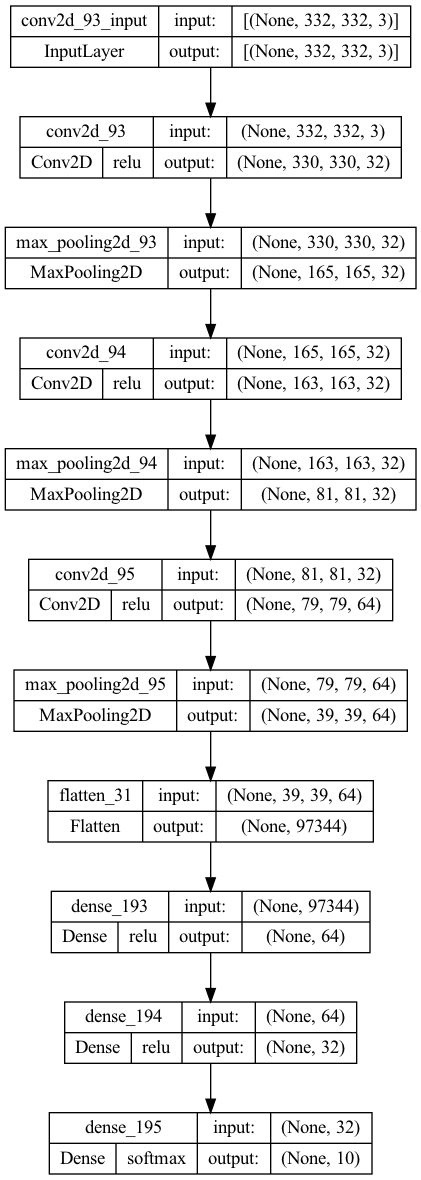

In [137]:
tf.keras.utils.plot_model(
    cnn,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)